## pyWAXS
#### Python-Based X-ray Scattering Data Reduction Notebook 
##### Toney Group, Updated: 10/18/2023, Example Notebook
------------

Note: Start by downloading/installing the 'pyWAXS.yml' virtual environment. Check the README.md or Git page for instructions on installation of this environment.

### Install pyWAXS Modules
Restart the Kernel after you do this.

In [1]:
# !python setup.py clean # uncomment if pip installation fails due to false path
%pip install -e /Users/keithwhite/github_repositories/pyWAXS # sub your pyWAXS/main directory here.

''' # Tips for troubleshooting pyWAXS installation.
# import importlib.util
# spec = importlib.util.find_spec("pywaxs") # uncomment to check the pywaxs origin information
# print(spec)

# !pip list # uncomment to check your imports list for pywaxs

# import sys # uncomment to check system pathes accessed by your kernel
# print(sys.path)
'''

Obtaining file:///Users/keithwhite/github_repositories/pyWAXS
  Preparing metadata (setup.py) ... done
  Attempting uninstall: pywaxs
    Found existing installation: pywaxs 0.2.0
    Uninstalling pywaxs-0.2.0:
      Successfully uninstalled pywaxs-0.2.0
  Running setup.py develop for pywaxs
Note: you may need to restart the kernel to use updated packages.


' # Tips for troubleshooting pyWAXS installation.\n# import importlib.util\n# spec = importlib.util.find_spec("pywaxs") # uncomment to check the pywaxs origin information\n# print(spec)\n\n# !pip list # uncomment to check your imports list for pywaxs\n\n# import sys # uncomment to check system pathes accessed by your kernel\n# print(sys.path)\n'

### Class & Module Imports

In [1]:
# - Custom Module Imports
from pywaxs import WAXSTransform
from pywaxs import WAXSSearch
from pywaxs import WAXSReduce, WAXSTOPAS
from pywaxs import WAXSFileManager as waxsfiles

# - Additional Module Imports
import xarray as xr # type: ignore
import pandas as pd # type: ignore
import numpy as np
import pathlib, os # , copy2
from pathlib import Path
from typing import Optional
import matplotlib.pyplot as plt
import math

/Users/keithwhite/github_repositories/pyWAXS/pywaxs/WAXSReduce.py:1030: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if order is None or order is np.NaN or order is 0:


#### Create a pyWAXS Project
Specify a 'project_name', if you already have a project with this name, the 'generate_projectPaths' method will just load those filepaths locally so you can access them. 

If you don't have a folder with the project_name, it will be automatically created for you, along with all of the subdirectories that come along with it. 

In [2]:
current_directory = os.getcwd() # get the current directory
basePath = Path(current_directory) # set the basePath
projectname = 'LaB6_SRM660c_Calib' # Change this for each sample.

# Generate project paths
projectPath, PathList = waxsfiles.generate_projectPaths(basePath, projectname)
basePath, dataPath, poniPath, maskPath, analysisPath, poscarPath, hdf5Path, pngPath, simulationPath = PathList

# Print results
print(f"Project Path: {projectPath}")
print(f"Data Path: {dataPath}")
print(f"PONI Path: {poniPath}")
print(f"MASK Path: {maskPath}")

Updated dataPath: /Users/keithwhite/github_repositories/pyWAXS/example/LaB6_SRM660c_Calib/data/LaB6_5.6m_12.7keV_corrected_1150.1s_x-1.601_th0.500_5.00s_1116949_maxs.tiff
Updated poniPath: /Users/keithwhite/github_repositories/pyWAXS/example/LaB6_SRM660c_Calib/poni/231017_newponi_LaB6_5.6m_12.7keV_corrected_1150.1s_x-1.601_th0.500_5.00s_1116949_maxs.poni
Updated maskPath: /Users/keithwhite/github_repositories/pyWAXS/example/LaB6_SRM660c_Calib/mask/LaB6_SRM660c_Calib_Mask.edf
Project Path: /Users/keithwhite/github_repositories/pyWAXS/example/LaB6_SRM660c_Calib
Data Path: /Users/keithwhite/github_repositories/pyWAXS/example/LaB6_SRM660c_Calib/data/LaB6_5.6m_12.7keV_corrected_1150.1s_x-1.601_th0.500_5.00s_1116949_maxs.tiff
PONI Path: /Users/keithwhite/github_repositories/pyWAXS/example/LaB6_SRM660c_Calib/poni/231017_newponi_LaB6_5.6m_12.7keV_corrected_1150.1s_x-1.601_th0.500_5.00s_1116949_maxs.poni
MASK Path: /Users/keithwhite/github_repositories/pyWAXS/example/LaB6_SRM660c_Calib/mask/LaB

#### (Optional) Select Project File Based on Scan ID

In [ ]:
# ## -- CHANGE THE PROJECT NAME & ScanID -- ##
# projectnames = ['002-D3_1-An-C2_DMF', '002-D4_1-An-C2_NMP', '002-D5_1-An-C2_6-1']
# scanIDs =  ['682375', '682387', '682399'] # Replace with the scanID you want to use

# i = 2 # select the sample
# projectname = projectnames[i]
# scanID = scanIDs[i]

# # -- Base Path Definitions -- #
# basePath = pathlib.Path('/Users/keithwhite/github_repositories/pyWAXS/examples_local/projects')
# projectPath, PathList = waxsfiles.generate_projectPaths(basePath, projectname)
# basePath, dataPath, poniPath, maskPath, analysisPath, poscarPath, hdf5Path, pngPath, simulationPath = PathList
# dataPath = waxsfiles.update_filePath(dataPath, 'tiff', scanID=scanID)

#### Define Metadata Keylist

In [3]:
metadata_keylist = ['sample', # Sample Number
                    'saxssdd', # Sample Chemistry
                    'energy', # Solution Filtration
                    'note', # Solution Concentration
                    'clocktime', # Clock time @ Endstation
                    'xpos', # X-Position of Beam
                    'thpos', # Incidence Angle
                    'exptime', # Exposure Time
                    'scanID', # Scan Identification Number (BNL Specific)
                    'detext'] # Extension of the detector identifier at BNL 'maxs' v. 'saxs' v, 'waxs'

#### Create a WAXSReduce Project Instance Example

In [4]:
# - WAXSReduce Class Instantiation: Load the data, apply mask, calculate and map q-range, Ewald sphere corrections/pixel splitting, and caked pixel splitting.
waxs_analysis = WAXSReduce(poniPath=poniPath, 
        maskPath=maskPath, 
        tiffPath=dataPath, 
        metadata_keylist=metadata_keylist,
        energy = 12.7)

#### Generate a .xye File for TOPAS

In [5]:
# Create a WAXSTOPAS instance based on the existing WAXSReduce instance
waxs_topas = WAXSTOPAS(projectPath=projectPath, waxs_instance=waxs_analysis)

# Now you can call the .xye generation method
waxs_topas.generate_xye_file_pyfai()

#### Plot the Reciprocal Space Map

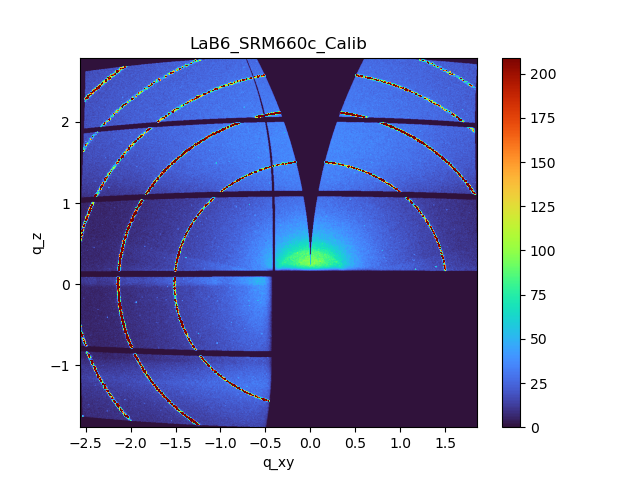

In [6]:
%matplotlib widget

title = projectname

waxs_analysis.display_image(waxs_analysis.reciptiff_xr, 
                            title=title, 
                            cmap='turbo')

#### Plot the 1D Integration

In [ ]:
waxs_analysis.plot1D(projectname=projectname)

## Generalized Analysis Flow

#### Image Processing

#### sin(chi) Correction

In [ ]:
# Caked Image Sin-Chi Correction: Apply sin(chi) correction to the caked image.
cakedtiff_sinchi_xr = waxs_analysis.sinchi_corr(chicorr = True, 
                                                qsqr = False)

# Image Normalization: Normalize the caked image.
cakedtiff_xr_norm, (max_x, max_y) = waxs_analysis.normalize_image(img = waxs_analysis.cakedtiff_sinchi_xr, 
                                                  normalizerecip=False)
data = cakedtiff_xr_norm

#### Image Folding

In [ ]:
# Image Folding: Fold the caked image.
folded_data = waxs_analysis.fold_image(data, 'chi')
data = folded_data

#### Interpolation

In [ ]:
data = waxs_analysis.cakedtiff_xr

# Image Normalization: Normalize the caked image.
data, (max_x, max_y) = waxs_analysis.normalize_image(img = data, 
                                                  normalizerecip=False)

# Image Interpolation: Interpolate the folded image.
# interpolator = ImageInterpolator() # Create the interpolator object. 
# data = interpolator.simple_interpolate(data, 'horizontal', 'slinear') # interpolate horizontal gaps with slinear method.
# data = interpolator.simple_interpolate(data, 'vertical', 'slinear') # interpolate unfilled vertical gaps with slinear method.

#### Plotting Output

In [ ]:
# Image Folding: Fold the caked image.
data = waxs_analysis.cakedtiff_xr
data = waxs_analysis.fold_image(data, 'chi')
data, (max_x, max_y) = waxs_analysis.normalize_image(img = data, 
                                                  normalizerecip=False)

# Display Image
waxs_analysis.display_image(data, 
                            title='folded', 
                            cmap='turbo')

#### Peak Finding
Find the peaks using a our custom peak finding algorithm.

Parameters:
- sigma1 (float, default=1.0): The standard deviation for the first Gaussian filter.
- sigma2 (float, default=2.0): The standard deviation for the second Gaussian filter.
- threshold (float, default=0.2): Threshold for initial peak identification.
- clustering_method (str, default='DBSCAN'): The clustering method to use ('DBSCAN' or 'HDBSCAN').
- eps (float, default=3): The maximum distance between two samples for them to be considered as in the same cluster (DBSCAN).
- min_samples (int, default=2): The number of samples in a neighborhood for a point to be considered as a core point (DBSCAN).
- k (int, default=3): The number of nearest neighbors to consider for the recentering algorithm.
- radius (float, default=5): The radius within which to search for neighbors in the recentering algorithm.
- edge_percentage (float, default=5): The percentage of the minimum edge length to be considered as the edge zone.
- stricter_threshold (float, default=0.01): A stricter threshold for edge peaks.

In [ ]:
'''
%matplotlib widget

# Find peaks (implement the actual peak-finding logic in the find_peaks method)
peak_finder = WAXSSearch(data) # create the WAXSSearch object

# NOTE: Make sure you pass the ACTIVE DataArray you are working on, notice how I passed 'data' 
# since this is the processed dataset we are working with locally.

dataset = peak_finder.waxssearch_main(sigma1=.1,
                                  sigma2=1.5,
                                  threshold=.015,
                                  clustering_method='HDBSCAN',
                                  eps=1, 
                                  min_samples=2,
                                  k=8,
                                  radius=10,
                                  edge_percentage=2,
                                  stricter_threshold=20)

# Display image with peaks
peak_finder.display_image_with_peaks_and_DoG(dataset,
                                       title='peak finder', 
                                       cmap='turbo')

# peak_finder.save_to_netcdf(hdf5Path) # Creates an hdf5 file with the name 'output.nc' in your output path. Will generalize
# the file naming convention for this soon.
'''

%matplotlib widget

data = waxs_analysis.reciptiff_xr
# data = waxs_analysis.fold_image(data, 'chi')
# data, (max_x, max_y) = waxs_analysis.normalize_image(img = data, 
#                                                   normalizerecip=False)

# Find peaks (implement the actual peak-finding logic in the find_peaks method)
peak_finder = WAXSSearch(data) # create the WAXSSearch object

# NOTE: Make sure you pass the ACTIVE DataArray you are working on, notice how I passed 'data' 
# since this is the processed dataset we are working with locally.

const_params = {
    'threshold': 0.0005,
    'clustering_method': 'HDBSCAN',
    'eps': 1,
    'min_samples': 2,
    'k': 4,
    'radius': 2,
    'edge_percentage': 2,
    'stricter_threshold': 20
}

dataset = peak_finder.waxssearch_main(sigma1=.15,
                                        sigma2=2.91,
                                        **const_params)

# Display image with peaks
peak_finder.display_image_with_peaks_and_DoG(dataset,
                                       title='peak finder', 
                                       cmap='turbo')

# peak_finder.save_to_netcdf(hdf5Path) # Creates an hdf5 file with the name 'output.nc' in your output path. Will generalize
# the file naming convention for this soon.

#### Peak Search Parameter Sensitivity Analysis

In [ ]:
#### Peak Search Parameter Sensitivity Analysis
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# Import the WAXSSearch class and any other dependencies here

# Define constant parameters
const_params = {
    'threshold': 0.0005,
    'clustering_method': 'HDBSCAN',
    'eps': 1,
    'min_samples': 2,
    'k': 4,
    'radius': 2,
    'edge_percentage': 2,
    'stricter_threshold': 5
}

# Assume that 'data' is available here or load it

# Define ranges for sigma1 and sigma2
sigma1_values = np.linspace(0.1, 1.2, 20)
sigma2_values = np.linspace(1.3, 3, 20)

# Create a matrix to store the results
num_peaks_matrix = np.zeros((len(sigma1_values), len(sigma2_values)))

# Run the simulation
for i, sigma1 in enumerate(sigma1_values):
    for j, sigma2 in enumerate(sigma2_values):
        # Create a WAXSSearch object with the current 'data'
        peak_finder = WAXSSearch(data)
        
        # Run the actual waxssearch_main method
        dataset = peak_finder.waxssearch_main(sigma1=sigma1,
                                              sigma2=sigma2,
                                              **const_params)
        
        # Extract the number of peaks found
        num_peaks = np.count_nonzero(dataset['peak_positions'].values == 1)
        num_peaks_matrix[i, j] = num_peaks


# Convert to DataFrame for better annotation in heatmap
df_num_peaks = pd.DataFrame(num_peaks_matrix, index=np.round(sigma1_values, 2), columns=np.round(sigma2_values, 2))

plt.close('all')

# Generate the heatmap
sns.heatmap(df_num_peaks, annot=True, fmt=".0f", cmap="YlGnBu")
plt.xlabel("Sigma2 Values")
plt.ylabel("Sigma1 Values")
plt.title("Heatmap of Number of Peaks Detected")
plt.show()

In [ ]:
import imageio  # for creating GIF
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# Import WAXSSearch and other dependencies here
# ...

# Assume that 'data' is available here or load it
# ...

# Define constant parameters
const_params = {
    'clustering_method': 'HDBSCAN',
    'eps': 1,
    'min_samples': 2,
    'k': 4,
    'radius': 2,
    'edge_percentage': 2,
    'stricter_threshold': 5
}

# Define ranges for sigma1, sigma2, and threshold
sigma1_values = np.linspace(0.1, 1.2, 20)
sigma2_values = np.linspace(1.3, 3, 20)
threshold_values = np.linspace(0.0001, 0.001, 10)  # Replace with your range

# Initialize a list to store heatmap frames
frames = []

# Loop over different threshold values
for t, threshold in enumerate(threshold_values):
    num_peaks_matrix = np.zeros((len(sigma1_values), len(sigma2_values)))

    for i, sigma1 in enumerate(sigma1_values):
        for j, sigma2 in enumerate(sigma2_values):
            if sigma1 >= sigma2:
                continue

            peak_finder = WAXSSearch(data)
            dataset = peak_finder.waxssearch_main(sigma1=sigma1, sigma2=sigma2, threshold=threshold, **const_params)
            num_peaks = np.count_nonzero(dataset['peak_positions'].values == 1)
            num_peaks_matrix[i, j] = num_peaks

    # Convert to DataFrame
    df_num_peaks = pd.DataFrame(num_peaks_matrix, index=np.round(sigma1_values, 2), columns=np.round(sigma2_values, 2))
    
    # Generate and save the heatmap
    plt.figure()
    sns.heatmap(df_num_peaks, annot=True, fmt=".0f", cmap="YlGnBu")
    plt.xlabel("Sigma2 Values")
    plt.ylabel("Sigma1 Values")
    plt.title(f"Heatmap of Number of Peaks Detected (Threshold={threshold})")
    
    # Save as PNG
    plt.savefig(f"heatmap_{t}.png")
    
    # Append to frames for GIF
    frames.append(imageio.imread(f"heatmap_{t}.png"))

# Create GIF
imageio.mimsave('heatmap.gif', frames, duration=1)  # 1-second duration for each frame

## Load Existing Project File

In [ ]:
# waxsPath = pathlib.Path('/Users/keithwhite/github_repositories/pyWAXS/examples_local/projects/1MAI_3PbI2_DMF_1M_mar23/analysis/hdf5/3MAI_1PbI2_DMF_1M_mar23_peaks.nc')
waxsPath = pathlib.Path('/Users/keithwhite/github_repositories/pyWAXS/examples_local/projects/1MAI_3PbI2_DMF_1M_mar23/analysis/hdf5/output.nc')

waxs_ds = waxs_analysis.load_xarray_dataset(waxsPath)

waxs_ds.info()

In [ ]:
waxs_ds_peaks = WAXSSearch(waxs_ds) # create the WAXSSearch object

# Display image with peaks
waxs_ds_peaks.display_image_with_peaks(waxs_analysis.ds,
                                       title='manual peaks', 
                                       cmap='turbo')

### 1D Integration Methods

In [ ]:
integrator = Integration1D(waxs_analysis)

Now your integrator object 'integrator' has access to and references your active 'waxs_analysis' session. 

It also has access to all of the WAXSReduce() methods. You can prove it to yourself like this:

#### (1) Cake Slide 1D: Display 2D Caked Image

In [ ]:
integrator.display_image(integrator.cakedtiff_xr, # Display the caked data we will manipulate with the 1D image processing.
                            title='processed', 
                            cmap='turbo')

#### (1) Cake Slice 1D

In [ ]:
integrator = Integration1D(waxs_analysis)

integrator.cakeslice1D(integrator.cakedtiff_xr, chislice=[-90, 90], qrslice=[0, 4], cakeslicesum='chi')

integrator.display_image1D(integrator.cakeslice1D_xr, color='red')

#### (2) Boxcut 1D: Display 2D Recip Space Map

In [ ]:
%matplotlib widget
# integrator = Integration1D(waxs_analysis)
integrator.display_image(integrator.reciptiff_xr, # Display the caked data we will manipulate with the 1D image processing.
                            title='recip space map', 
                            cmap='turbo')

#### (2) Box Cut 1D

In [ ]:
# Updated `process_slices` function to dynamically generate a sample name prefix based on the slices
def process_slices(integrator, base_samplenameprefix, pngPath, plot_interpolated=False, interpolate_gaps = False, interp_method = 'linear', order = None):
    # Qz Layer Lines
    qxyslice_qz = [-2.5, 2.5]
    qzslice_qz_list = [
        [.42, .57],
        [.9, 1.07],
        [1.42, 1.58],
        [1.83, 2.16],
        [2.4, 2.6]
    ]
    
    for qzslice in qzslice_qz_list:
        dynamic_samplenameprefix = f"{base_samplenameprefix}_qxyrange{qxyslice_qz[0]}_{qxyslice_qz[1]}_qzrange{qzslice[0]}_{qzslice[1]}"
        title = generate_title('qz', qxyslice_qz, qzslice)
        integrator.boxcut1D(integrator.reciptiff_xr, qxyslice=qxyslice_qz, qzslice=qzslice, boxcutsum='qz', interpolate_gaps=interpolate_gaps, interp_method = interp_method, order = None)
        integrator.display_image1D(integrator, color='blue', title=title, save_image=True, samplenameprefix=dynamic_samplenameprefix, savePath=pngPath, plot_interpolated=plot_interpolated)
        
    # Qxy Layer Lines
    qzslice_qxy = [0, 3]
    qxyslice_qxy_list = [
        [-0.95, -0.7],
        [-1.18, -1.08],
        [-1.7, -1.45],
        [-2.06, -1.9],
        [-2.24, -2.1],
        [-2.36, -2.26]
    ]
    
    for qxyslice in qxyslice_qxy_list:
        dynamic_samplenameprefix = f"{base_samplenameprefix}_qxyrange{qxyslice[0]}_{qxyslice[1]}_qzrange{qzslice_qxy[0]}_{qzslice_qxy[1]}"
        title = generate_title('qxy', qxyslice, qzslice_qxy)
        integrator.boxcut1D(integrator.reciptiff_xr, qxyslice=qxyslice, qzslice=qzslice_qxy, boxcutsum='qxy', interpolate_gaps=interpolate_gaps, interp_method = interp_method)
        integrator.display_image1D(integrator, color='red', title=title, save_image=True, samplenameprefix=dynamic_samplenameprefix, savePath=pngPath, plot_interpolated=plot_interpolated)
        
# The generate_title function for reference
def generate_title(boxcutsum, qxyslice=None, qzslice=None):
    if boxcutsum == 'qz':
        title = f"Qz Layer Lines (Qxy: {qzslice[0]} to {qzslice[1]})"
    elif boxcutsum == 'qxy':
        title = f"Qxy Layer Lines (Qz: {qxyslice[0]} to {qxyslice[1]})"
    return title

In [ ]:
base_samplenameprefix = '3MAI1PbI2_DMF_1M'
# interp_method = 'cubic', 'slinear', 'nearest', 'zero', 'linear'
interp_method = 'linear'
process_slices(integrator, base_samplenameprefix, pngPath, plot_interpolated=False, interpolate_gaps = False, interp_method = 'linear', order = None)

#### (3) Pole Figure 1D: Display 2D Caked Image

In [ ]:
integrator.display_image(integrator.cakedtiff_xr, # Display the caked data we will manipulate with the 1D image processing.
                            title='processed', 
                            cmap='turbo')

#### (3) Pole Figure 1D

In [ ]:
# integrator.polefig1D(integrator.cakedtiff_xr, pole_chislice=[-90, 90], pole_qrslice=[1.8, 1.92], qrcenter=1.85, chicenter=0, poleleveler='linear')
integrator.polefig1D(integrator.cakedtiff_xr, pole_chislice=[-90, 90], pole_qrslice=[.62, .75], qrcenter=.67, chicenter=0, poleleveler='average')
# integrator.polefig1D(integrator.cakedtiff_xr, pole_chislice=[-90, 90], pole_qrslice=[.62, .75], qrcenter=.67, chicenter=0, poleleveler=None)
# integrator.polefig1D(integrator.cakedtiff_xr, pole_chislice=[-90, 90], pole_qrslice=[.62, .75], qrcenter=.67, chicenter=0, poleleveler='linear')

integrator.display_image1D(integrator.polefig1D_xr, color='blue')

#### (4) Azimuthal Integration: Display the 2D Recip Space Map
This is effectively the same as the caked integration, but with our own custom pixel splitting routine.

In [ ]:
integrator.display_image(integrator.reciptiff_xr, # Display the caked data we will manipulate with the 1D image processing.
                            title='recip space map', 
                            cmap='turbo')

#### (a) Setup DataPaths & Metadata Keys Example

In [ ]:
# -- Base Path Definitions -- #
basePath = pathlib.Path('/Users/keithwhite/github_repositories/pyWAXS/example')
dataPath = basePath.joinpath('data') # Generalized path for data.
poniPath = basePath.joinpath('poni') # PONI (.poni) File
maskPath = basePath.joinpath('mask') # MASK (.edf, .json)
outputPath = basePath.joinpath('output') # Generalized for file outputs

# -- Example Specific Paths -- #
# TIFF File w/ Data
tiffPath = dataPath.joinpath('sam22_1MAI1PbI2_unfilt_0p3M_5p0scfh_Si_30uL_043_2068.2s_x0.015_th0.300_0.49s_986546_001639_maxs.tiff')
# PONI File Calibrant
poniPath = poniPath.joinpath('may23_poni4_nslsiimar23_12p7keV_CeO_KWPos_mask5_fit2.poni')
# Image Mask File
maskPath = maskPath.joinpath('may23_nslsiimar23_12p7keV_AgBh_KWPos_wSi_th0p3_mask_5.edf')
# Output for HDF5 File Format (a nicely formatted output file we will use)
hdf5Path = outputPath.joinpath('hdf5') # output path for generated hdf5 files

# -- TIFF Path & Corresponding Metadata Keylist -- #
# Look at your filename, each '_' delimiter spaces out two keys. Add one key for each position in the filename.
metadata_keylist = ['samplenum', # Sample Number
                    'chemistry', # Sample Chemistry
                    'filter', # Solution Filtration
                    'concentration', # Solution Concentration
                    'purge_rate', # Spincoater Purge Rate
                    'substrate', # Sample Substrate
                    'solution_volume', # Dispensed Volume
                    'runnum', # Run Number @ Beamtime Session
                    'clocktime', # Clock time @ Endstation
                    'xpos', # X-Position of Beam
                    'thpos', # Incidence Angle
                    'exptime', # Exposure Time
                    'scanID', # Scan Identification Number (BNL Specific)
                    'framenum', # Frame number for tr-GIWAXS series exposures (in-situ time series)
                    'detext'] # Extension of the detector identifier at BNL 'maxs' v. 'saxs' v, 'waxs'

#### (b) Create Project Session

In [ ]:
# - WAXSReduce Class Instantiation
waxs_analysis = WAXSReduce(poniPath=poniPath, 
        maskPath=maskPath, 
        tiffPath=tiffPath, 
        metadata_keylist=metadata_keylist,
        energy = 12.7)

##### Notice how we loaded all of the following: image correction file references, the X-ray energy, and the data?

Assuming your file has the incidence angle in the sample name, we can generate accurately corrected images. You can now access the reciprocal space image corrections and caked image corrections:

Reciprocal Space Map:
```python
waxs_analysis.reciptiff_xr
```

Caked Image:
```python
waxs_analysis.cakedtiff_xr
```

In [ ]:
waxs_analysis.reciptiff_xr

##### Note how we had to use the syntax:
```python
waxs_analysis.
```
##### to access the the data.
This is how we access the instance that refers to your analysis project. You can have multiple instances coexist in the same notebook.

Now, click the 'Attributes' dropdown above. We loaded the data into an XArray DataArray (DA). 
##### All of the keys listed above in the setup were used to extract your metadata from the filename.

### (2) Image Plotting Examples

#### (a) Display Image (Generalized Plotting)

In [ ]:
%matplotlib widget

# -- Display the Caked Image
# waxs_analysis.cakeddisplay_xr() # method 1

# waxs_analysis.display_image(waxs_analysis.cakedtiff_xr, # method 2
waxs_analysis.display_image(waxs_analysis.cakedtiff_xr, 
                            title='caked image', 
                            cmap='turbo')

##### You can plot the data stored as attributes with one of a set of built-in methods, or a generalized method.

Custom Method (Caked Image):
```python
waxs_analysis.cakeddisplay_xr()
```
General Method Equivalent:
```python
waxs_analysis.display_image(waxs_analysis.cakedtiff_xr, 
                            title='Caked Image', 
                            cmap='turbo')
```

#### (b) Quick Plotting Methods

##### (i) Raw Data

In [ ]:
%matplotlib widget
waxs_analysis.rawdisplay_xr()
# waxs_analysis.rawtiff_xr

##### (ii) Reciprocal Space Map

In [ ]:
%matplotlib widget
waxs_analysis.recipdisplay_xr()
# waxs_analysis.reciptiff_xr

##### (iii) Caked Image

In [ ]:
%matplotlib widget
waxs_analysis.cakeddisplay_xr()
# waxs_analysis.cakedtiff_xr

### (3) 2D Image Processing Examples

#### (a) Image Intensity Correction (sin(chi)) Example

In [ ]:
%matplotlib widget

cakedtiff_sinchi_xr = waxs_analysis.sinchi_corr(chicorr = True, 
                                                qsqr = False)

waxs_analysis.display_image(waxs_analysis.cakedtiff_sinchi_xr, 
                            title='caked image, sin(chi) corrected', 
                            cmap='turbo')

#### (b) Image Normalization Example

In [ ]:
%matplotlib widget

# Generate the normalized reciprocal space map image
cakedtiff_xr_norm, (max_x, max_y) = waxs_analysis.normalize_image(img = waxs_analysis.cakedtiff_sinchi_xr, 
                                                  normalizerecip=False)

# Check if the returned image is None or not of a compatible type
if cakedtiff_xr_norm is None or not isinstance(cakedtiff_xr_norm, (np.ndarray, xr.DataArray)):
    raise ValueError("The normalized image is None or not of a compatible type.")

print ('Maximum Intensity Pixel Coordinate: ', 'x: ', max_x, 'y: ', max_y)

# Display the normalized image
waxs_analysis.display_image(cakedtiff_xr_norm, 
                            title='caked, sin(chi) corrected, normalized', 
                            cmap='turbo')


#### (c) Image Folding Example

In [ ]:
# Create a WAXS_Analyze instance and test the fold_image method
# waxs = WAXS_Analyze()
# original_data = .cakedtiff_xr.copy()
# folded_data = waxs.fold_image(waxs.cakedtiff_xr, 'chi')

original_data = cakedtiff_xr_norm
# original_data = waxs_analysis.cakedtiff_xr
folded_data = waxs_analysis.fold_image(original_data, 'chi')

# Display the original and folded data for validation
# original_data, folded_data

waxs_analysis.display_image(folded_data, 
                            title='caked, sin(chi) corrected, normalized, folded', 
                            cmap='turbo')

#### (d) Image Interpolation Example

In [ ]:
import matplotlib.pyplot as plt

%matplotlib widget

data = folded_data

interpolator = ImageInterpolator()
data = interpolator.simple_interpolate(data, 'horizontal', 'slinear')
data = interpolator.simple_interpolate(data, 'vertical', 'slinear')
# data = interpolator.patch_interpolate(data)

# interpolator.save_dataarray_to_netcdf(interpolated_img, 'test_file')

waxs_analysis.display_image(data, 
                            title='interpolated', 
                            cmap='turbo')

''' # -- Testing Different Interpolation Algorithms
# interpolated_img = interpolator.patch_interpolate(data)
# interp_horizontal = interpolator.linear_interpolate(data, 'horizontal')
# interp_vertical = interpolator.linear_interpolate(data, 'vertical')
# interpolated = interpolator.simple_interpolate(data, 'vertical', 'linear')

# # Create an instance of the ImageInterpolator class
# interpolator = ImageInterpolator()

# # Define methods and directions
# # methods = ["linear", "nearest", "zero", "slinear", "quadratic", "cubic",
# #            "polynomial", "barycentric", "krog", "pchip", "spline", "akima"]
# methods = ["linear", "nearest", "zero", "slinear", "akima"]
# directions = ["vertical", "horizontal"]

# # Let's visualize all the interpolated results to understand how each method performs.

# # Dictionary to store the results
# interpolated_results = {}

# # Iterate through all combinations of methods and directions to perform interpolation
# for method in methods:
#     for direction in directions:
#         try:
#             interpolated_img = interpolator.simple_interpolate(data.copy(), direction, method)
#             key = f"{method}_{direction}"
#             interpolated_results[key] = interpolated_img
#         except Exception as e:
#             print(f"Skipped {method} in {direction} direction due to error: {e}")

# # Let's visualize all the interpolated results to understand how each method performs.
# fig, axes = plt.subplots(len(methods), len(directions), figsize=(20, 40))
# axes = axes.flatten()

# for i, (key, data) in enumerate(interpolated_results.items()):
#     ax = axes[i]
#     data.plot(ax=ax, add_colorbar=False, cmap='turbo')
#     ax.set_title(f"Method: {key}")

# plt.tight_layout()
# plt.show()
'''

#### (e) Image Smoothing Example

In [ ]:
%matplotlib widget
# import matplotlib.pyplot as plt
# from matplotlib.colors import LogNorm
# cmap = plt.cm.turbo
# cmap.set_bad('black')

waxs_analysis.smooth_image(folded_data, method='gaussian', sigma=1e-6)

smoothed_image, (max_x, max_y) = waxs_analysis.normalize_image(img = waxs_analysis.smoothed_img, normalizerecip=False)

print ('Maximum Intensity Pixel Coordinate: ', 'x: ', max_x, 'y: ', max_y)

# Display the smoothed image with appropriate coordinates using the 'display_image' method
# plt = waxs_analysis.display_image(waxs_analysis.smoothed_img, 
waxs_analysis.display_image(waxs_analysis.smoothed_img, 
                            title='caked, sin(chi) corrected, normalized, folded, smoothed', 
                            cmap='turbo')


#### (f) 2D Image Peak Finding Example

In [ ]:
%matplotlib widget

data = None
data = folded_data
# Find peaks (implement the actual peak-finding logic in the find_peaks method)

data = waxs_analysis.find_peaks_DoG (data, 
                                     sigma1=.4, 
                                     sigma2=2, 
                                     threshold=0.008, 
                                     clustering_method='HDBSCAN', 
                                     eps=1, 
                                     min_samples=2, 
                                     k=3, 
                                     radius=5)

# Display image with peaks
waxs_analysis.display_image_with_peaks_and_DoG(data,
                                       title='peak finder', 
                                       cmap='turbo')

### (4) 1D Data Reduction (Integration)

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
cmap = plt.cm.turbo
cmap.set_bad('black')
plt.close('all')

# DA = waxs_analysis.cakedtiff_xr
# DA = cakedtiff_sinchi_xr
DA = waxs_analysis.smoothed_img
# DA, (max_x, max_y) = waxs_analysis.normalize_image(img = waxs_analysis.cakedtiff_xr, normalizerecip=False)

colors = cmap(np.linspace(0,1,10))
# fig, axs = plt.subplots(1, 2, figsize=(9,3))
# plot.line(ax=axs[0], color=colors[i])

axs = DA.sum('chi').sel(method='nearest').sel(qr=slice(0.2,3)).plot.line(color=colors[9])
plt.show()

### (5) Saving/Exporting & Loading Project Sessions

#### (a) Exporting a Project

In [ ]:
basePath = pathlib.Path('/Users/keithwhite/github_repositories/pyWAXS/examples')
zarrPath = basePath.joinpath('output_files/zarr_files')
projectName = 'test_project'
waxs_analysis.exportzarr(zarrPath=zarrPath, projectName=projectName)

#### (b) Load an Existing Project

In [ ]:
basePath = pathlib.Path('/Users/keithwhite/github_repositories/pyWAXS/examples')
zarrPath = basePath.joinpath('output_files/zarr_files')
projectName = 'test_project'
waxs_analysis = WAXSReduce(zarrPath = zarrPath, projectName = projectName)

## Additional Examples

#### Smoothing Image

In [ ]:
%matplotlib widget

# Smooth the image using the 'smooth_image' method
# smoothed_image = waxs_analysis.smooth_image(waxs_analysis.reciptiff_xr.values, 
#                                             method='gaussian', 
#                                             sigma=.05)

smoothed_image = waxs_analysis.smooth_image(waxs_analysis.reciptiff_xr, 
                                            method='gaussian', 
                                            sigma=1)
# smoothed_image = waxs_analysis.normalize_image()
# smoothed_image = waxs_analysis.smooth_image(smoothed_image, method='total_variation', sigma=100)

# Display the smoothed image with appropriate coordinates using the 'display_image' method
waxs_analysis.display_image(smoothed_image, 
                            title='Smoothed Image', 
                            cmap='jet')


#### Signal-to-Noise Calculation

In [ ]:
smoothed_image = waxs_analysis.calculate_SNR(smoothed_image)
# waxs_analysis.snrtemp
waxs_analysis.reciptiff_xr.SNR

#### Create a Class to Compare Simulated (.int) Files to Real Data

In [ ]:
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd

def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

def lorentzian(x, A, mu, gamma):
    return A * (1 / np.pi) * (gamma / ((x - mu)**2 + gamma**2))

def pseudo_voigt(x, A, mu, sigma, gamma, eta):
    return eta * gaussian(x, A, mu, sigma) + (1 - eta) * lorentzian(x, A, mu, gamma)

class TraceComparison:
    def __init__(self, trace1, trace2):
        self.trace1 = trace1
        self.trace2 = trace2
        self.background_params = None
        self.optimized_background = pd.Series(dtype='float64')
    
    def normalize_to_max(self):
        max1 = self.trace1['intensity'].max()
        max2 = self.trace2['intensity'].max()
        self.trace1.loc[:, 'intensity'] /= max1
        self.trace2.loc[:, 'intensity'] /= max2

    def normalize_to_baseline(self, q_min, q_max):
        baseline1 = self.trace1[(self.trace1['q'] >= q_min) & (self.trace1['q'] <= q_max)]['intensity'].mean()
        baseline2 = self.trace2[(self.trace2['q'] >= q_min) & (self.trace2['q'] <= q_max)]['intensity'].mean()
        self.trace1['intensity'] /= baseline1
        self.trace2['intensity'] /= baseline2

    def find_peaks(self, height, distance):
        self.peaks1, _ = find_peaks(self.trace1['intensity'], height=height, distance=distance)
        self.peaks2, _ = find_peaks(self.trace2['intensity'], height=height, distance=distance)

    def compare_peak_widths(self):
        self.widths1 = self.trace1.iloc[self.peaks1]['q'].values
        self.widths2 = self.trace2.iloc[self.peaks2]['q'].values

    def calculate_residual(self):
        # Create interpolation functions for the intensity values based on 'q'
        f1 = interp1d(self.trace1['q'], self.trace1['intensity'], kind='linear', fill_value="extrapolate")
        f2 = interp1d(self.trace2['q'], self.trace2['intensity'], kind='linear', fill_value="extrapolate")

        # Create a common 'q' range
        common_q = np.linspace(max(self.trace1['q'].min(), self.trace2['q'].min()),
                            min(self.trace1['q'].max(), self.trace2['q'].max()),
                            num=max(len(self.trace1['q']), len(self.trace2['q'])))

        # Interpolate the intensity values to the common 'q' range
        common_intensity1 = f1(common_q)
        common_intensity2 = f2(common_q)

        # Calculate the residual
        self.residual = pd.Series(common_intensity1 - common_intensity2, index=common_q, name='residual')

    def minimize_residual(self):
        min_q = max(self.trace1['q'].min(), self.trace2['q'].min())
        max_q = min(self.trace1['q'].max(), self.trace2['q'].max())
        common_range = (self.trace1['q'] >= min_q) & (self.trace1['q'] <= max_q)
        
        x = self.trace1.loc[common_range, 'q']
        y1 = self.trace1.loc[common_range, 'intensity']
        y2 = self.trace2.loc[common_range, 'intensity']

        params, _ = curve_fit(pseudo_voigt, x, y1 - y2)
        self.fitted_curve = pseudo_voigt(x, *params)
        self.residual = y1 - (y2 + self.fitted_curve)

    def optimize_background(self):
        def objective(params):
            noise_level, slope, intercept = params
            background = noise_level + slope * self.trace2['q'] + intercept
            modified_trace2 = self.trace2['intensity'] + background
            f1 = interp1d(self.trace1['q'], self.trace1['intensity'], kind='linear', fill_value="extrapolate")
            f2 = interp1d(self.trace2['q'], modified_trace2, kind='linear', fill_value="extrapolate")

            # Define a common 'q' range
            common_q = np.linspace(max(self.trace1['q'].min(), self.trace2['q'].min()),
                                   min(self.trace1['q'].max(), self.trace2['q'].max()),
                                   num=max(len(self.trace1['q']), len(self.trace2['q'])))

            residual = f1(common_q) - f2(common_q)
            return np.sum(residual ** 2)

        initial_guess = [0, 0, 0] if self.background_params is None else self.background_params
        result = minimize(objective, initial_guess, method='L-BFGS-B')
        self.background_params = result.x

        # Apply the optimized background to the trace intensities
        self.optimized_background = self.background_params[0] + self.background_params[1] * self.trace2['q'] + self.background_params[2]
        self.trace2.loc[:, 'intensity'] += self.optimized_background
        self.trace2.loc[:, 'background'] = self.optimized_background  # Store the background in the DataFrame

        self.calculate_residual()
        
    def plot_normalization(self):
        plt.figure()
        plt.plot(self.trace1['q'], self.trace1['intensity'], label='Trace 1')
        plt.plot(self.trace2['q'], self.trace2['intensity'], label='Trace 2')
        plt.title('Normalized Traces')
        plt.xlabel('q')
        plt.ylabel('Intensity')
        plt.legend()
        plt.show()
        
    def plot_peaks(self):
        plt.figure()
        plt.plot(self.trace1['q'], self.trace1['intensity'], label='Trace 1')
        plt.plot(self.trace1['q'].iloc[self.peaks1], self.trace1['intensity'].iloc[self.peaks1], 'x', label='Peaks 1')
        plt.plot(self.trace2['q'], self.trace2['intensity'], label='Trace 2')
        plt.plot(self.trace2['q'].iloc[self.peaks2], self.trace2['intensity'].iloc[self.peaks2], 'o', label='Peaks 2')
        plt.title('Peak Positions')
        plt.xlabel('q')
        plt.ylabel('Intensity')
        plt.legend()
        plt.show()
        
    def plot_residual(self):
        plt.figure()
        plt.plot(self.trace1.loc[self.residual.index, 'q'], self.residual, label='Residual')
        plt.title('Residual Between Traces')
        plt.xlabel('q')
        plt.ylabel('Intensity Difference')
        plt.legend()
        plt.show()
        
    def plot_minimization(self):
        plt.figure()
        plt.plot(self.trace1['q'], self.residual + self.fitted_curve, label='Fitted Curve')
        plt.plot(self.trace1['q'], self.residual, label='Original Residual')
        plt.title('Minimized Residual')
        plt.xlabel('q')
        plt.ylabel('Intensity Difference')
        plt.legend()
        plt.show()

    def save_traces_to_csv(self, trace1_filename, trace2_filename, savepath=None):
        if savepath:
            savepath = Path(savepath)
            savepath.mkdir(parents=True, exist_ok=True)
            trace1_filepath = savepath / trace1_filename
            trace2_filepath = savepath / trace2_filename
        else:
            trace1_filepath = trace1_filename
            trace2_filepath = trace2_filename
        
        self.trace1.to_csv(trace1_filepath, index=False)
        self.trace2.to_csv(trace2_filepath, index=False)

    @classmethod
    def load_and_plot_traces(cls, trace1_path, trace2_path, savepath=None):
        trace1 = pd.read_csv(trace1_path)
        trace2 = pd.read_csv(trace2_path)

        plt.figure(figsize=(6, 4))
        plt.plot(trace1['q'], trace1['intensity'], label='Trace 1')
        plt.plot(trace2['q'], trace2['intensity'], label='Trace 2')
        plt.xlabel('q')
        plt.ylabel('Intensity')
        plt.legend()
        plt.title('Loaded Traces')
        
        if savepath:
            savepath = Path(savepath)
            plt.savefig(savepath)
        
        plt.show()

In [ ]:
# Initialize the TraceComparison object
bbox_df = pd.DataFrame({'q': waxs_analysis.integrate1d_da.qr.values, 'intensity': waxs_analysis.integrate1d_da.values})

# Filter out data below q-value of 0.5
bbox_df = bbox_df[bbox_df['q'] >= 0.5]
filtered_data = filtered_data[filtered_data['q'] >= 0.5]

# Initialize the TraceComparison object and perform calculations
comparison = TraceComparison(bbox_df, filtered_data)
comparison.normalize_to_max()
comparison.calculate_residual()

# Plot initial comparison and residual
plt.figure(figsize=(6, 10))

# Plot the normalized traces
plt.subplot(4, 1, 1)
plt.plot(comparison.trace1['q'], comparison.trace1['intensity'], label='pygix bbox (Normalized)', color='b')
plt.plot(comparison.trace2['q'], comparison.trace2['intensity'], label='Loaded .int File (Normalized)', color='g')
plt.title('Initial Comparison of Traces')
plt.xlabel('q')
plt.ylabel('Intensity')
plt.legend()

# Plot the initial residual
plt.subplot(4, 1, 2)
plt.plot(comparison.residual.index, comparison.residual.values, label='Initial Residual', color='r')
plt.title('Initial Residual')
plt.xlabel('q')
plt.ylabel('Intensity Difference')
plt.legend()

# Optimize the background
comparison.optimize_background()

# Plot the normalized traces with optimized background
plt.subplot(4, 1, 3)
plt.plot(comparison.trace1['q'], comparison.trace1['intensity'], label='pygix bbox (Normalized)', color='b')
plt.plot(comparison.trace2['q'], comparison.trace2['intensity'], label='Loaded .int File (Normalized)', color='g')
plt.title('Comparison of Traces (With Optimized Background)')
plt.xlabel('q')
plt.ylabel('Intensity')
plt.legend()

# Plot the new residual
plt.subplot(4, 1, 4)
plt.plot(comparison.residual.index, comparison.residual.values, label='New Residual', color='r')
plt.title('New Residual')
plt.xlabel('q')
plt.ylabel('Intensity Difference')
plt.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

plt.show()

# Initialize the TraceComparison object and perform calculations
# comparison = TraceComparison(bbox_df, filtered_data)
# comparison.normalize_to_max()
# comparison.calculate_residual()

# # Save the traces for debugging
# comparison.save_traces_to_csv('trace1.csv', 'trace2.csv', savepath=savepath)

In [ ]:
# Correct file paths
trace1_path = Path('/Users/keithwhite/github_repositories/pyWAXS/examples_local/projects/LaB6_SRM660c_Calib/analysis/simulation/trace1_saved.csv')
trace2_path = Path('/Users/keithwhite/github_repositories/pyWAXS/examples_local/projects/LaB6_SRM660c_Calib/analysis/simulation/trace2_saved.csv')

# Load and plot the traces
TraceComparison.load_and_plot_traces(trace1_path, trace2_path)

#### Developing Image Stitching Class

In [ ]:
# Required module imports for the ImageStitching class
from pathlib import Path
from typing import List, Tuple
from skimage import io, feature, color
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import corner_harris, corner_peaks
import cv2

class ImageStitching:
    def __init__(self, files: List[Path]):
        self.files = files
        self.images_original = []
        self.images_gray = []
        self.keypoints_list = []
        self.load_and_preprocess_images()

    @staticmethod
    def convert_to_8bit(image):
        image_norm = (image - np.min(image)) / (np.max(image) - np.min(image))
        return (image_norm * 255).astype(np.uint8)
    
    def load_and_preprocess_images(self):
        for file in self.files:
            image_original = io.imread(file)
            self.images_original.append(image_original)
            
            if len(image_original.shape) == 3:
                image_gray = color.rgb2gray(image_original)
            else:
                image_gray = image_original
            
            image_gray = self.convert_to_8bit(image_gray)
            self.images_gray.append(image_gray)

    def find_sift_keypoints(self):
        self.keypoints_list = []
        for i, image_gray in enumerate(self.images_gray):
            keypoints, _ = self.detect_features(image_gray)
            keypoints = np.array([kp.pt for kp in keypoints])
            self.keypoints_list.append(keypoints)

    @staticmethod
    def detect_features(image):
        sift = cv2.SIFT_create()
        return sift.detectAndCompute(image, None)
    
    '''
    def display_keypoints(self, index: int, title='Image', cmap='turbo'):
        img_values = self.images_gray[index]
        keypoints = self.keypoints_list[index]
        
        vmin = np.nanpercentile(img_values, 10)
        vmax = np.nanpercentile(img_values, 99)
    
        plt.imshow(np.flipud(img_values),
                   cmap=cmap,
                   vmin=vmin,
                   vmax=vmax,
                   aspect='auto')
        
        # Draw keypoints on top of the image
        for keypoint in keypoints:
            x, y = keypoint
            plt.scatter(x, y, s=10, c='red', marker='o')
        
        plt.title(title)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.colorbar()
        plt.show()
    '''
    
    def display_keypoints(self, index: int, title='Image', cmap='turbo'):
        # plt.close('all')
        img_values = self.images_gray[index]
        keypoints = self.keypoints_list[index]
        
        vmin = np.nanpercentile(img_values, 10)
        vmax = np.nanpercentile(img_values, 99)
    
        plt.imshow(np.flipud(img_values),
                   cmap=cmap,
                   vmin=vmin,
                   vmax=vmax,
                   aspect='auto')
        
        # Draw keypoints on top of the image
        for keypoint in keypoints:
            x, y = keypoint
            plt.scatter(x, y, s=10, c='red', marker='o')
        
        plt.title(title)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.colorbar()
        plt.show()
    
    def find_keypoints(self, n_keypoints: int = 5000, fast_threshold: float = 0.01):
        for image_gray in self.images_gray:
            orb = feature.ORB(n_keypoints=n_keypoints, fast_threshold=fast_threshold)
            orb.detect_and_extract(image_gray)
            self.keypoints_list.append(orb.keypoints)

    def plot_original(self, index: int):
        image = self.images_original[index]
        vmin, vmax = np.nanpercentile(image, [10, 99])
        plt.imshow(image, cmap='turbo', vmin=vmin, vmax=vmax)
        plt.title("Original Image")
        plt.show()
        
    def plot_keypoints(self, index: int):
        image = self.images_original[index]
        keypoints = self.keypoints_list[index]
        vmin, vmax = np.nanpercentile(image, [10, 99])
        plt.imshow(image, cmap='turbo', vmin=vmin, vmax=vmax)
        plt.plot(keypoints[:, 1], keypoints[:, 0], 'r.', markersize=5)
        plt.title("Keypoints")
        plt.show()
        
    def find_harris_keypoints(self, min_distance: int = 5):
        self.keypoints_list = []
        for image_gray in self.images_gray:
            harris_response = corner_harris(image_gray)
            keypoints = corner_peaks(harris_response, min_distance=min_distance)
            self.keypoints_list.append(keypoints)

    def plot_original_with_keypoints(self, index: int):
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))
        
        # Original Image
        image = self.images_original[index]
        vmin, vmax = np.nanpercentile(image, [10, 99])
        axs[0].imshow(image, cmap='turbo', vmin=vmin, vmax=vmax)
        axs[0].set_title("Original Image")
        
        # Keypoints
        keypoints = self.keypoints_list[index]
        axs[1].imshow(image, cmap='turbo', vmin=vmin, vmax=vmax)
        axs[1].plot(keypoints[:, 1], keypoints[:, 0], 'r.', markersize=5)
        axs[1].set_title("Keypoints")
        
        plt.tight_layout()
        plt.show()

    def plot_sift_keypoints(self, index: int):
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))
        
        # Original Image
        image = self.images_original[index]
        vmin, vmax = np.nanpercentile(image, [10, 99])
        axs[0].imshow(image, cmap='turbo', vmin=vmin, vmax=vmax)
        axs[0].set_title("Original Image")
        
        # SIFT Keypoints
        keypoints = self.keypoints_list[index]
        print(f"Plotting Image {index}: Keypoints shape: {keypoints.shape}")  # Add debug print
        axs[1].imshow(image, cmap='turbo', vmin=vmin, vmax=vmax)
        # axs[1].plot(keypoints[:, 0], keypoints[:, 1], 'r.', markersize=5)  # Corrected indexing
        axs[1].plot(keypoints[:, 1], keypoints[:, 0], 'r.', markersize=5)
        axs[1].set_title("SIFT Keypoints")
        
        plt.tight_layout()
        plt.show()

In [ ]:
from pathlib import Path

# Initialize the class and find keypoints with local file paths for the example
files = [
    Path("/Users/keithwhite/github_repositories/pyWAXS/examples_local/projects/1MAI_3PbI2_DMF_1M_jun23/stitch/sam16_3mai1pbi2_dmf_1m_5scfh_Si_40uL_010_2356.6s_x-0.001_th0.300_10.00s_1116233_maxs.tiff"),
    Path("/Users/keithwhite/github_repositories/pyWAXS/examples_local/projects/1MAI_3PbI2_DMF_1M_jun23/stitch/sam16_3mai1pbi2_dmf_1m_5scfh_Si_40uL_010_2461.2s_x-0.001_th0.300_10.00s_1116234_maxs.tiff")
]

stitcher_sift = ImageStitching(files)

plt.close('all')

# Find and visualize SIFT keypoints
stitcher_sift.find_sift_keypoints()
stitcher_sift.display_keypoints(0, title='Image 1')
# stitcher_sift.display_keypoints(1, title='Image 2')

In [ ]:
stitcher_sift.display_keypoints(1, title='Image 2')

In [ ]:
# Check if xfeatures2d module is available
sift_available = "xfeatures2d" in cv2.__dict__
if sift_available:
    print("SIFT is available in OpenCV.")
else:
    print("SIFT is not available in OpenCV.")


In [ ]:
# Initialize the class and find keypoints with local file paths for the example
files = [
    Path("/Users/keithwhite/github_repositories/pyWAXS/examples_local/projects/1MAI_3PbI2_DMF_1M_jun23/stitch/sam16_3mai1pbi2_dmf_1m_5scfh_Si_40uL_010_2356.6s_x-0.001_th0.300_10.00s_1116233_maxs.tiff"),
    Path("/Users/keithwhite/github_repositories/pyWAXS/examples_local/projects/1MAI_3PbI2_DMF_1M_jun23/stitch/sam16_3mai1pbi2_dmf_1m_5scfh_Si_40uL_010_2461.2s_x-0.001_th0.300_10.00s_1116234_maxs.tiff")
]

# Initialize the class and find SIFT keypoints
stitcher_sift = ImageStitching(files)
stitcher_sift.find_sift_keypoints()

# Test the new plotting method for SIFT keypoints
stitcher_sift.plot_sift_keypoints(0)


In [ ]:
# Initialize the class and find keypoints with local file paths for the example
files = [
    Path("/Users/keithwhite/github_repositories/pyWAXS/examples_local/projects/1MAI_3PbI2_DMF_1M_jun23/stitch/sam16_3mai1pbi2_dmf_1m_5scfh_Si_40uL_010_2356.6s_x-0.001_th0.300_10.00s_1116233_maxs.tiff"),
    Path("/Users/keithwhite/github_repositories/pyWAXS/examples_local/projects/1MAI_3PbI2_DMF_1M_jun23/stitch/sam16_3mai1pbi2_dmf_1m_5scfh_Si_40uL_010_2461.2s_x-0.001_th0.300_10.00s_1116234_maxs.tiff")
]

# Initialize the class and find SIFT keypoints
stitcher_sift = ImageStitching(files)
stitcher_sift.find_sift_keypoints()

# Test the new plotting method for SIFT keypoints
stitcher_sift.plot_sift_keypoints(0)

# Example usage
# stitcher_example = ImageStitching(local_files)
# stitcher_example.find_keypoints()

# Note: The actual images won't be loaded in this environment due to path constraints. This is just for demonstration.
# stitcher_example.files
# Re-initialize the class and find keypoints with the initially uploaded files (as local files are not accessible here)

# Test the plotting methods
# stitcher_example.plot_original(0)
# stitcher_example.plot_keypoints(0)
# stitcher_example.plot_original_with_keypoints(0)


#### Image Processer Class

In [ ]:
# Include the required imports for the class
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Modify the ImageProcessor class to match the given contrast scaling method
class ImageProcessor:
    @staticmethod
    def convert_to_8bit(image):
        image_norm = (image - np.min(image)) / (np.max(image) - np.min(image))
        return (image_norm * 255).astype(np.uint8)
    
    @staticmethod
    def detect_features(image):
        sift = cv2.SIFT_create()
        return sift.detectAndCompute(image, None)
    
    @staticmethod
    def display_image(img, ax, title='Image', cmap='turbo'):
        if img is None or not isinstance(img, np.ndarray):
            raise ValueError("The input image is None or not of a compatible type.")
        
        img_values = img
        if np.all(np.isnan(img_values)) or img_values.size == 0:
            raise ValueError("The input image is empty or contains only NaN values.")
        
        vmin = np.nanpercentile(img_values, 10)
        vmax = np.nanpercentile(img_values, 99)
        ax.imshow(np.flipud(img_values),
                   cmap=cmap,
                   vmin=vmin,
                   vmax=vmax,
                   aspect='auto')
        ax.set_title(title)
        ax.axis('off')
        
    def process_and_display_single_image(self, image, title='Image'):
        # Convert to 8-bit grayscale
        image_8bit = self.convert_to_8bit(image)
        
        # Detect features (keypoints)
        keypoints, _ = self.detect_features(image_8bit)
        
        # Create a figure with 2 subplots
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        
        # Display the original image in the first subplot
        self.display_image(image_8bit, axes[0], title=f'{title} - Original')
        
        # Display the keypoints in the second subplot
        img_keypoints = cv2.drawKeypoints(image_8bit, keypoints, None)
        self.display_image(img_keypoints, axes[1], title=f'{title} - {len(keypoints)} Keypoints')
        
        plt.show()

# Instantiate the ImageProcessor class
processor = ImageProcessor()

# Process and display each image one by one
for i, img in enumerate(images):
    processor.process_and_display_single_image(img, title=f'Image {i+1}')

In [ ]:
# Instantiate the ImageProcessor class
processor = ImageProcessor()

# Process and display each image one by one
for i, img in enumerate(images):
    processor.process_and_display_single_image(img, title=f'Image {i+1}')